In [10]:
%matplotlib inline
%matplotlib nbagg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
import random
from collections import defaultdict
import pickle

from typing import *
from IPython.display import Image, display, clear_output

sns.set_style("whitegrid")

#from plotting import make_vae_plots
from Code.Dataloader import dataloader
from Code.MakeDict import findEDF
from Code.MNEplotter import MNEPlotter,plot_AC,plot_2d_latents 
from Code.Main import make_batch



#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

>> Using device: cpu


# 1. Introduction

##  1.1) Load data

Load the EEG data using Andreas' data loader mechanism.

In [11]:
#CHANGE PATH ACCORDINGLY
data_path=r"C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset"
path=r"artifact_dataset"
# Initialize dataloader
edfDict=findEDF(DataDir=data_path)
DL=dataloader(Time_interval=1,Overlap=0,Data_paht=data_path)
lables_decoding=DL.one_hot_eoncoding

In [12]:
data_path=r"C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset"
path=r"artifact_dataset"

#### [START SKIP] 

SKIP THIS PART UNLESS SETTINGS ARE CHANGED.

Find all annotations for al windows.

In [3]:
'''
#Find all atifacts in dataset takes 2 minutes
edfDict,annothlist=DL.anno_mapping(edfDict) 
'''

'\n#Find all atifacts in dataset takes 2 minutes\nedfDict,annothlist=DL.anno_mapping(edfDict) \n'

In [4]:
'''
#So save it
np.save('testIDX.npy',annothlist)
'''

"\n#So save it\nnp.save('testIDX.npy',annothlist)\n"

#### [END SKIP] 

In [13]:
#Or load it
annothlist=np.load('Code/testIDX.npy',allow_pickle=True)

### Functions for formatting the data

In [14]:
def reshape(x):
    if len(x.size())>1:
        return x.view(-1,*original_shape)
    return x.view(original_shape)

In [15]:
def undo_one_hot_enc(y):
    return torch.Tensor(np.array([(yi == 1).nonzero()[0][0] for yi in y])).type(torch.int)  

In [25]:
def load(batch_size = 24):
    windowlist,filelist=make_batch(annothlist, size = batch_size)
    _,batch_X,batch_Y=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

    x = torch.Tensor(batch_X).type(torch.float)
    y = undo_one_hot_enc(batch_Y)
    
    return x.to(device), y.to(device)

## 1.2) Plot randomly chosen samples on a grid

In [16]:
idx = [0]
test_dict = DL.loadDict(edfDict,index = idx);

In [11]:
ploter=MNEPlotter(CH_names=DL.CH_names,lableEncoding=DL.one_hot_eoncoding) #Intitalic plotter

In [19]:
ploter.plot(test_dict[0]['window_0'])

NameError: name 'ploter' is not defined

#### 1.3) Using  the transform argument,  implement dynamic binarization,  where  the  binarized {0,1} pixels are sampled using the pixel intensity as the probability - DONE

# 2. VAE Implementation

## 2.1 Setting up the model

In [18]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [63]:
sample_x, sample_y = load()

In [20]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        '''
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        self.px_logits = px_logits
        dist = torch.distributions.bernoulli.Bernoulli(logits=px_logits)
        '''      
        h_z = self.decoder(z)
        self.hz = h_z
        h_z = h_z.view(-1,*self.input_shape)
        self.hz = h_z
        #mu, log_sigma =  h_z.chunk(2, dim=-1)
        #dist = torch.distributions.normal.Normal(h_z, h_z)

        return torch.distributions.normal.Normal(h_z, h_z)
      

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        self.test = px.sample()
        
        # evaluate log probabilities
        self.px_log = px.log_prob(x)
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [27]:
latent_features = 2
# Vi 
vi = VariationalInference(beta=1.0)

vae = VariationalAutoencoder(sample_x.size()[1:], latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4750, bias=True)
  )
)


### (Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [28]:
untrained_samples = vae.sample(sample_x)

tensor([[[ 9.3963e-06,  9.0668e-06,  7.9106e-06,  ..., -1.3476e-05,
          -1.0424e-05, -1.1452e-05],
         [-4.6417e-06, -6.1921e-06, -7.8059e-06,  ...,  7.1232e-06,
           7.5814e-06,  8.8419e-06],
         [ 1.4432e-05,  1.1966e-05,  1.2862e-07,  ..., -1.5307e-05,
          -9.0507e-06, -1.0994e-05],
         ...,
         [-4.4894e-06, -6.3443e-06, -9.1795e-06,  ..., -3.5576e-06,
          -1.4216e-06, -1.6048e-07],
         [-9.0671e-06, -1.0617e-05, -1.2384e-05,  ..., -3.5576e-06,
          -2.9475e-06, -1.5338e-06],
         [-5.2215e-07, -6.9855e-07, -3.2941e-07,  ...,  4.3770e-06,
           3.9190e-06,  3.0439e-06]],

        [[-3.2734e-05, -2.9779e-05, -2.5506e-05,  ...,  1.2552e-04,
           1.4374e-04,  1.2915e-04],
         [-2.9682e-05, -2.8711e-05, -2.5201e-05,  ...,  1.1118e-04,
           1.1063e-04,  9.3448e-05],
         [-1.2440e-05, -1.2231e-05, -1.2537e-05,  ...,  3.9115e-06,
           7.0186e-06,  8.7622e-06],
         ...,
         [-2.3884e-05, -2

<IPython.core.display.Javascript object>


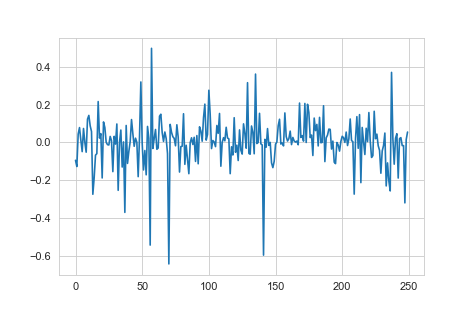

<IPython.core.display.Javascript object>


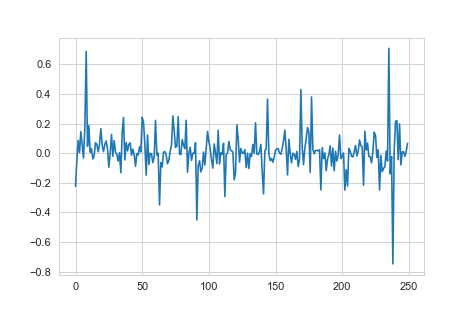

<IPython.core.display.Javascript object>


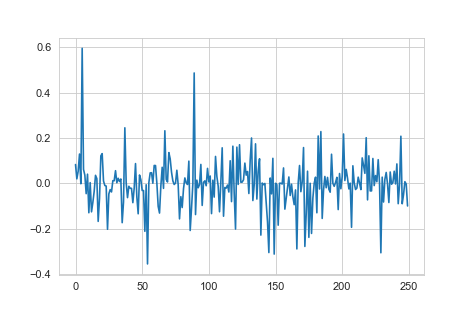

<IPython.core.display.Javascript object>


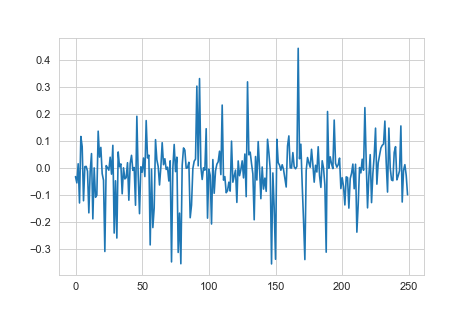

<IPython.core.display.Javascript object>


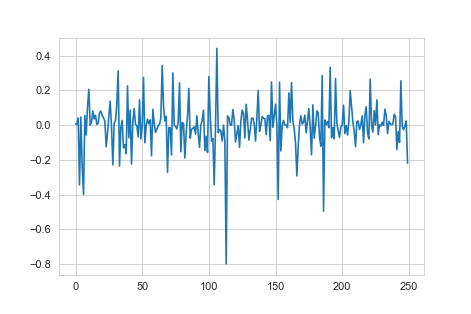

<IPython.core.display.Javascript object>


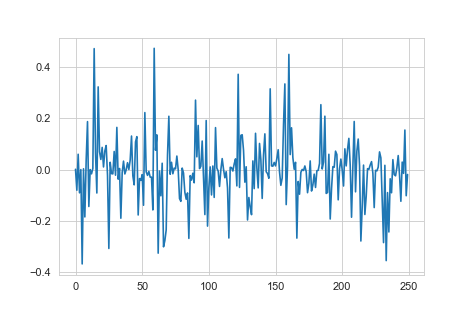

<IPython.core.display.Javascript object>


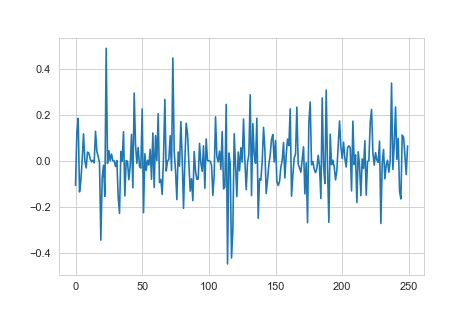

<IPython.core.display.Javascript object>


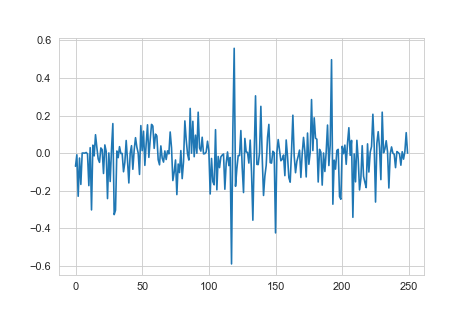

<IPython.core.display.Javascript object>


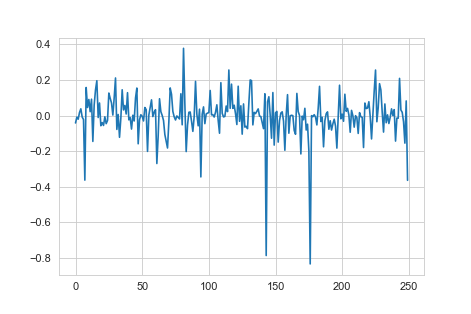

<IPython.core.display.Javascript object>


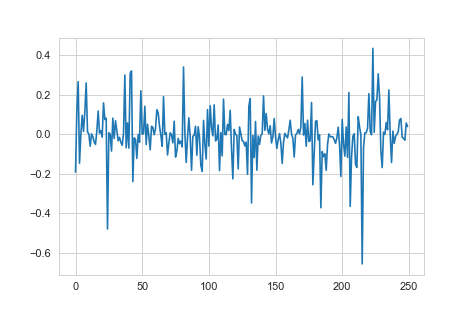

<IPython.core.display.Javascript object>


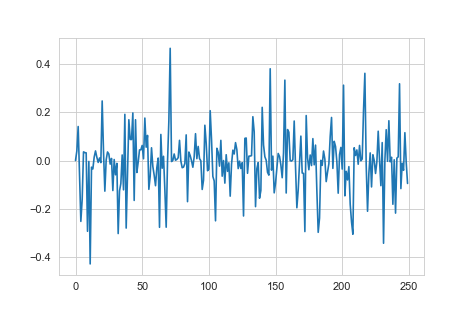

<IPython.core.display.Javascript object>


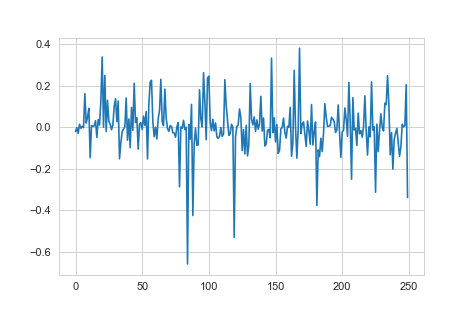

<IPython.core.display.Javascript object>


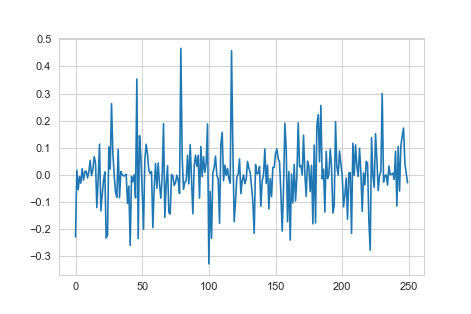

<IPython.core.display.Javascript object>


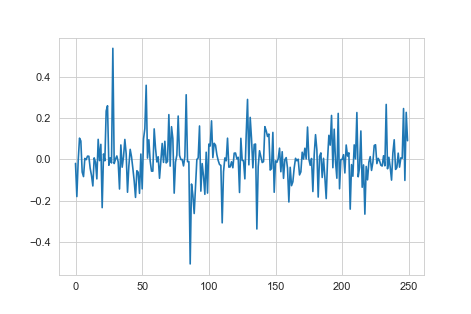

<IPython.core.display.Javascript object>


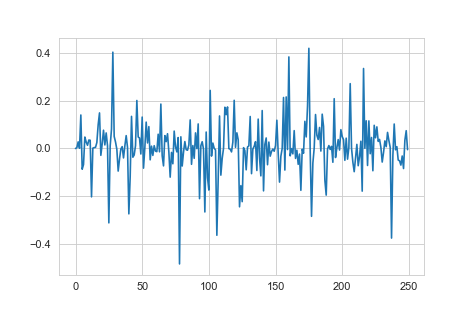

<IPython.core.display.Javascript object>


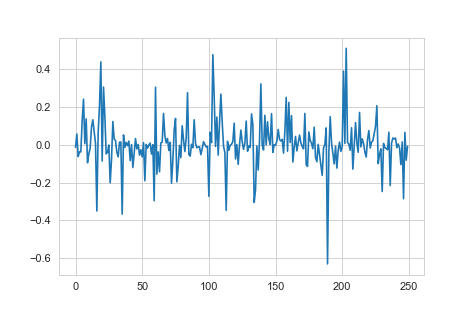

<IPython.core.display.Javascript object>


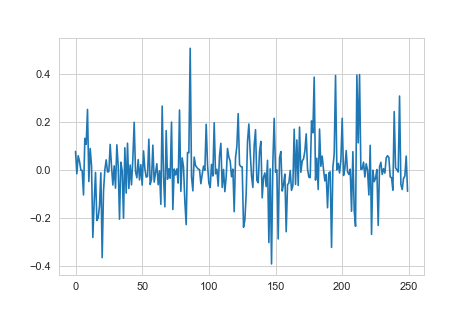

<IPython.core.display.Javascript object>


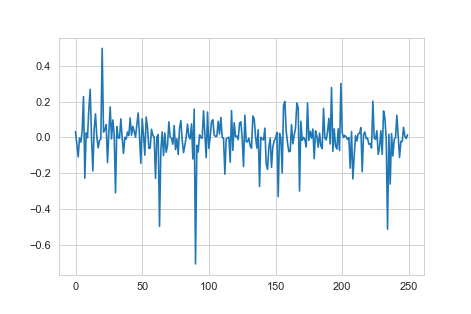

<IPython.core.display.Javascript object>


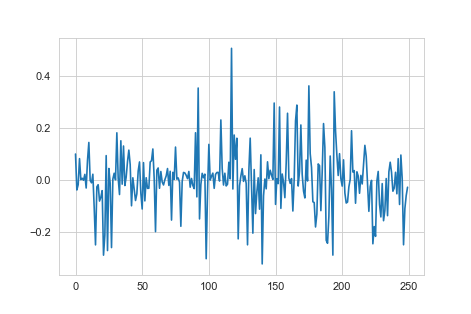

In [34]:
print(sample_x)
for channel in untrained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

<IPython.core.display.Javascript object>


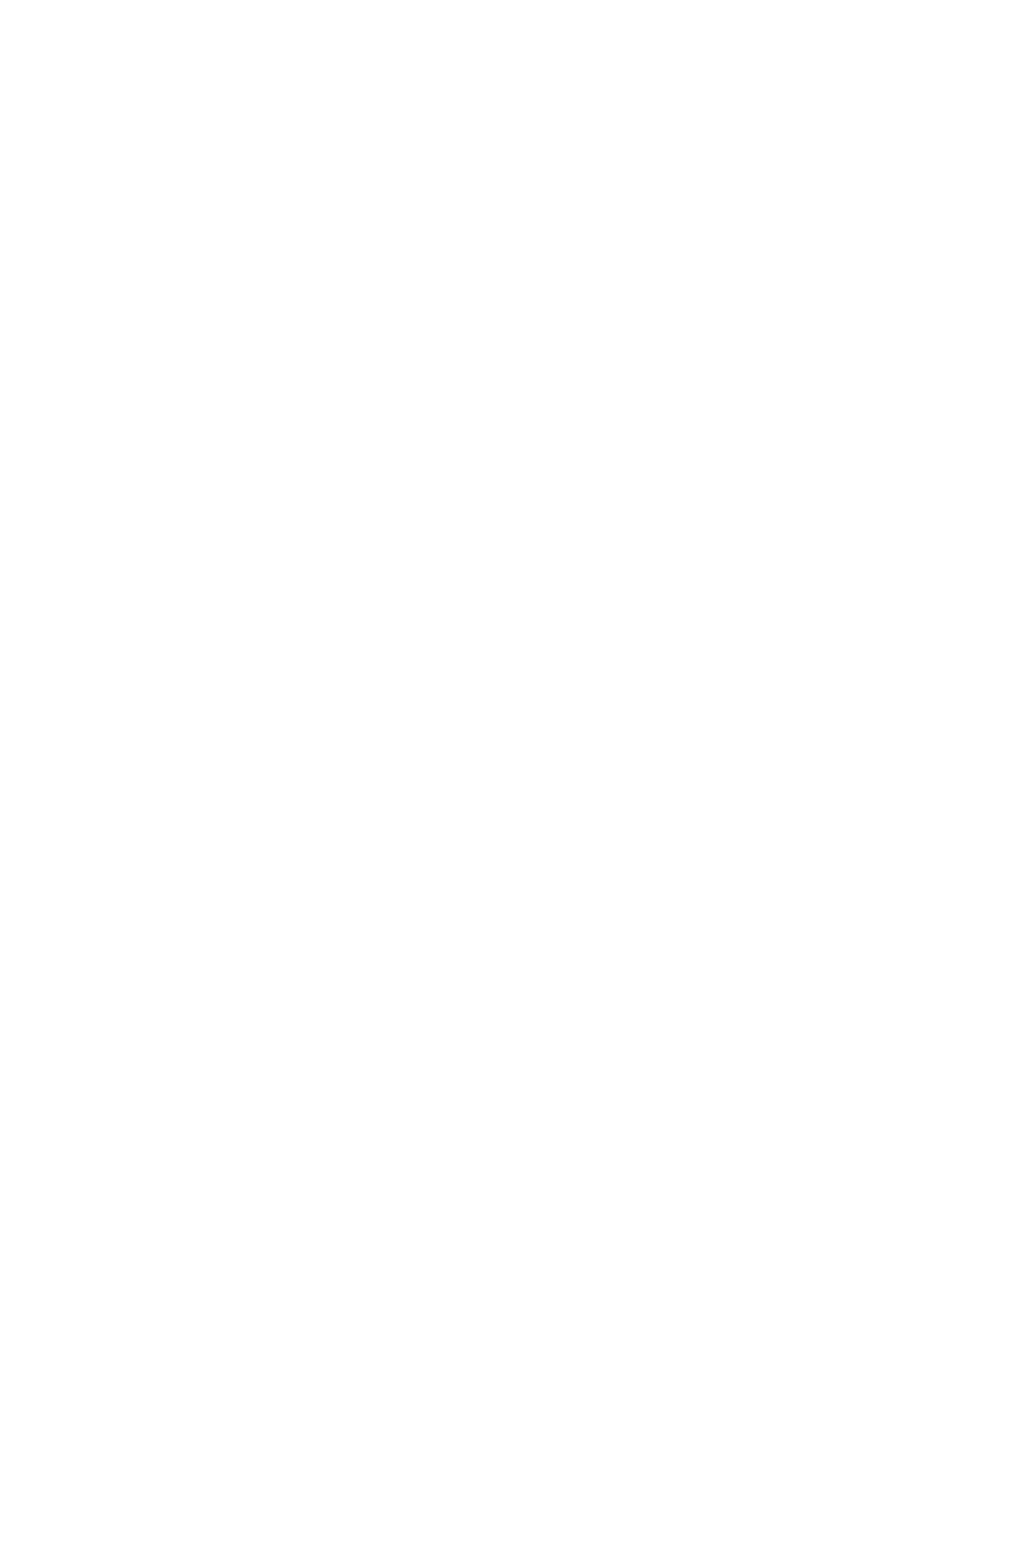

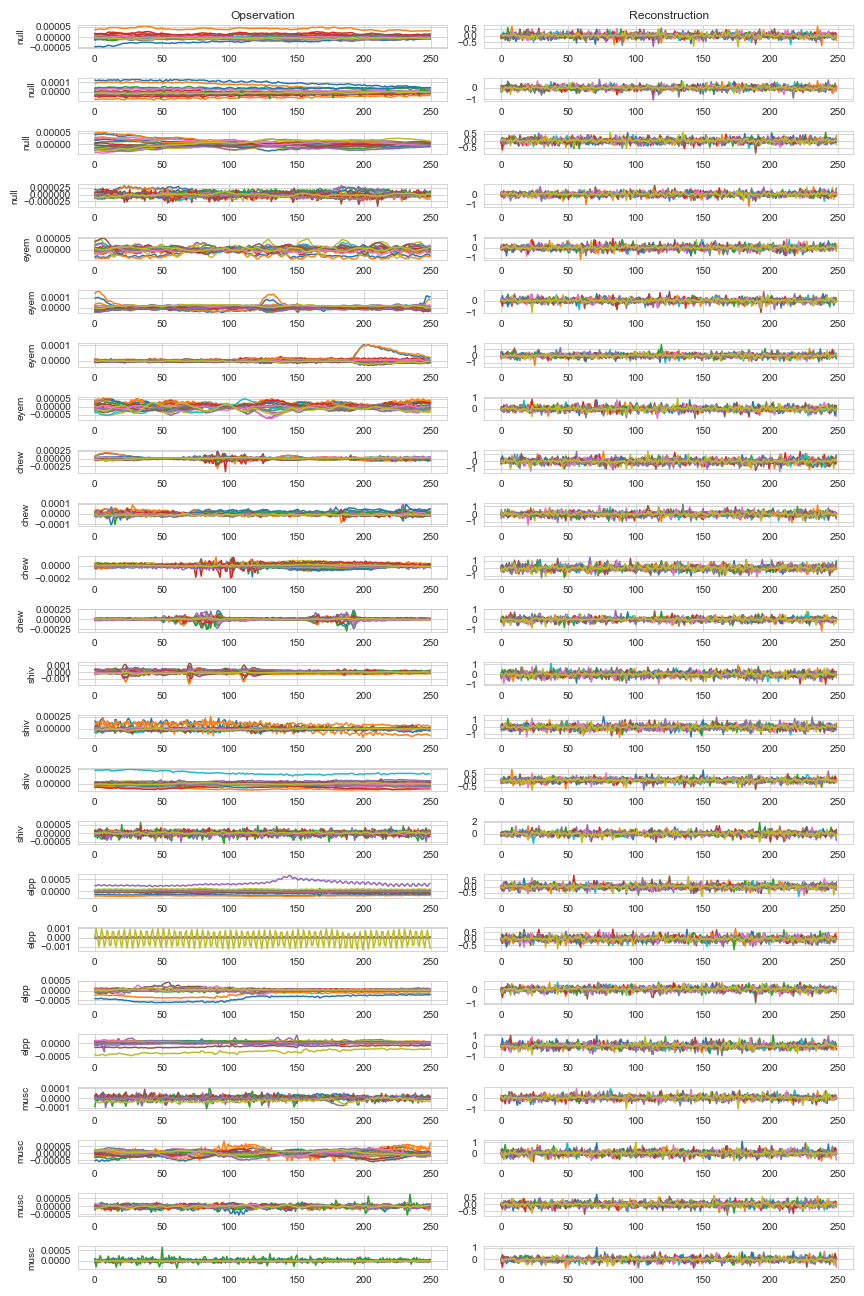

In [90]:
#plt.rcParams.update({'figure.max_open_warning': 0})
def plot_batch(x,x_new=[None],y=[None],channel=0,figsize=(12,18),tmp_img="test_batchplot.png",show=True):
    
    size,n_chanel,signal_len=x.shape
    
    if y != [None]:
        write_lable=True
        decoding=["null","eyem","chew","shiv","elpp","musc"]
    else:
        write_lable=False
    
    if x_new != [None]:
        plot_new=True
        fig, axis=plt.subplots(size,2,figsize=figsize)
    else:
        plot_new=False
        fig, axis=plt.subplots(size,1,figsize=figsize)
    for n in range(0,size):
        if plot_new:
            
            ax0=axis[n,0]
            ax1=axis[n,1]
            for CH in range(0,19):
                ax0.plot(x[n][CH])
                ax1.plot(x_new[n][CH])
            if write_lable:
                ax0.set_ylabel(decoding[y[n]])
                
            axis[0,0].set_title("Opservation")
            axis[0,1].set_title("Reconstruction")
        else:
            
            ax=axis[n]
            for CH in range(0,19):
                ax.plot(x[n][CH])
            if write_lable:
                ax.set_ylabel(decoding[y[n]])
                
            # display
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    if show:
        display(Image(filename=tmp_img))
        clear_output(wait=True)

plot_batch(sample_x,x_new=untrained_samples,y=sample_y)

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [120]:
elbo = vae.elbo(sample_x)

In [121]:
plt.plot(elbo.detach().numpy()) # Why does this not work?
plt.show()

## 2.2 Setting up the training

In [24]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Vi 
vi = VariationalInference(beta=1.0)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

# move the model to the device
vae = vae.to(device)

### 1. Implement a train(...)function that performs one epoch of training

In [39]:
def train(vae,n_batches= 10):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for batch in range(n_batches):
        x,_ = load()
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

### 2. Implement a test(...)function that evaluates the model on the test set.

In [30]:
def test(vae,validation_data):
    global outputs,x,y
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x,y = load()
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save the state dict of themodel using torch.save!

[**SKIP the above if the training is finished. Just load the model.**]

In [47]:
# train
epoch = 0
num_epochs = 1
validation_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae,n_batches= 3)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae,validation_data)

Epoch 0/1
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006440\s001_2010_04_17\00006440_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 430249  =      0.000 ...  1720.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006531\s003_2010_09_20\00006531_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302249  =      0.000 ...  1208.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',

PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006885\s001_2010_09_18\00006885_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\U

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s003_2012_07_16\00006535_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P

In [24]:
'''
# save model
path = "Saved_Models/model.pt"
torch.save(vae.state_dict(), path)
'''

'\n# save model\npath = "model.pt"\ntorch.save(vae.state_dict(), path)\n'

**[END SKIP]**

In [26]:
# train model
path = "Saved_Models/model.pt"
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [31]:
trained_samples = vae.sample(sample_x)

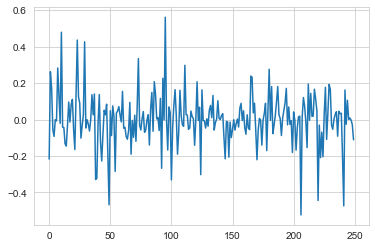

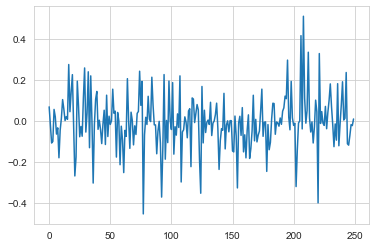

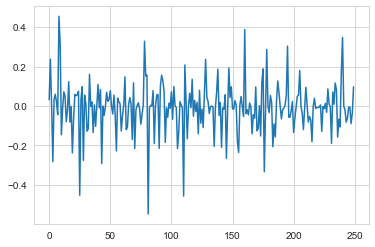

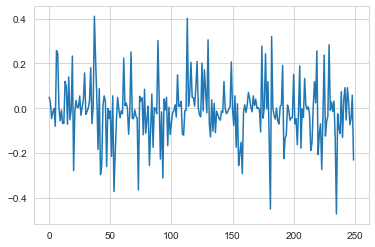

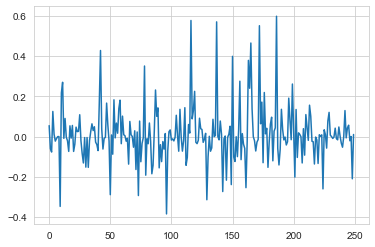

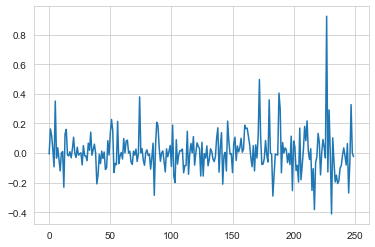

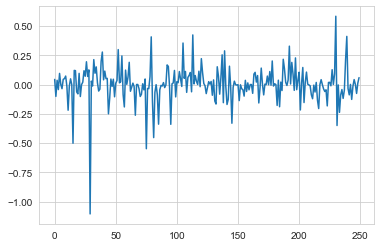

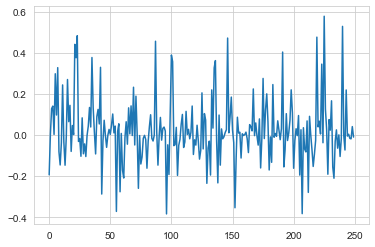

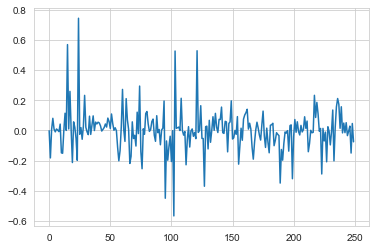

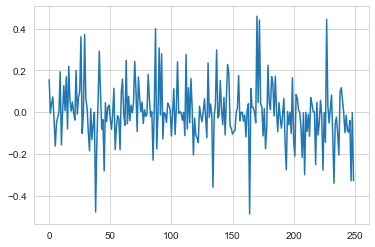

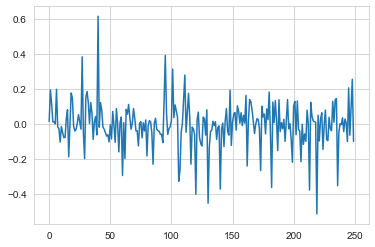

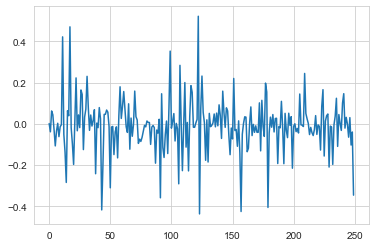

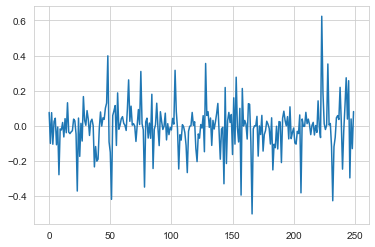

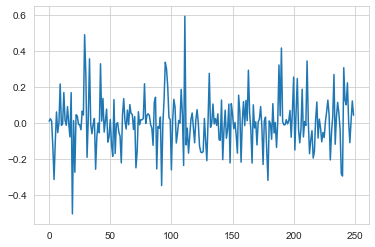

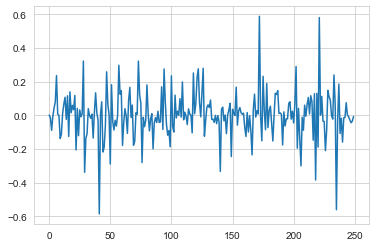

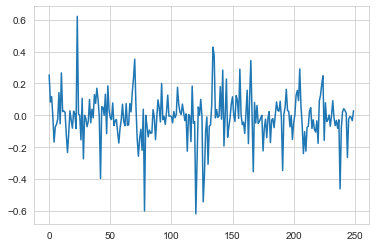

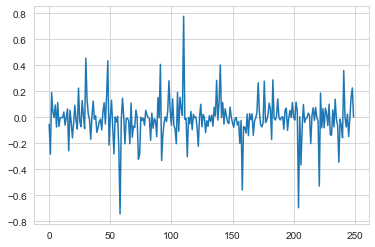

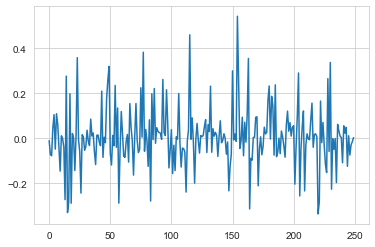

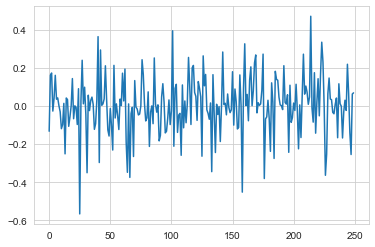

In [27]:
for channel in trained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

### 5.(Report)Evaluate thetrained modelon the test set and report the number.

### Make a plots functions: right now it's random. 

In [17]:
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
from torch.distributions import Normal
from torchvision.utils import make_grid
import os
make_vae_plots(vae, sample_x, sample_y, outputs, training_data, validation_data,figsize=(24, 6))

NameError: name 'make_vae_plots' is not defined

In [100]:
def plot_interpolations(ax, vae):
    print("Plot interpolations")
    device = next(iter(vae.parameters())).device
    nrow = 10
    nsteps = 10
    prior_params = vae.prior_params.expand(2 * nrow, *vae.prior_params.shape[-1:])
    mu, log_sigma = prior_params.chunk(2, dim=-1)
    pz = Normal(mu, log_sigma.exp())
    z = pz.sample().view(nrow, 2, -1)
    t = torch.linspace(0, 1, 10, device=device)
    zs = t[None, :, None] * z[:, 0, None, :] + (1 - t[None, :, None]) * z[:, 1, None, :]
    px = vae.observation_model(zs.view(nrow * nsteps, -1))
    x = px.sample()
    x = x.to('cpu')
    #x_grid = make_grid(x.view(-1, 1, 19, 250), nrow=nrow).permute(1, 2, 0)
    #ax.imshow(x_grid)
    ax.plot(x)
    ax.axis('off')

In [101]:
def plot_grid(ax, vae):
    print("plot grid")
    device = next(iter(vae.parameters())).device
    nrow = 10
    xv, yv = torch.meshgrid([torch.linspace(-3, 3, 10), torch.linspace(-3, 3, 10)])
    zs = torch.cat([xv[:, :, None], yv[:, :, None]], -1)
    zs = zs.to(device)
    px = vae.observation_model(zs.view(nrow * nrow, 2))
    x = px.sample()
    x = x.to('cpu')
    x_grid = make_grid(x.view(-1, 1, 19, 250), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')


<IPython.core.display.Javascript object>


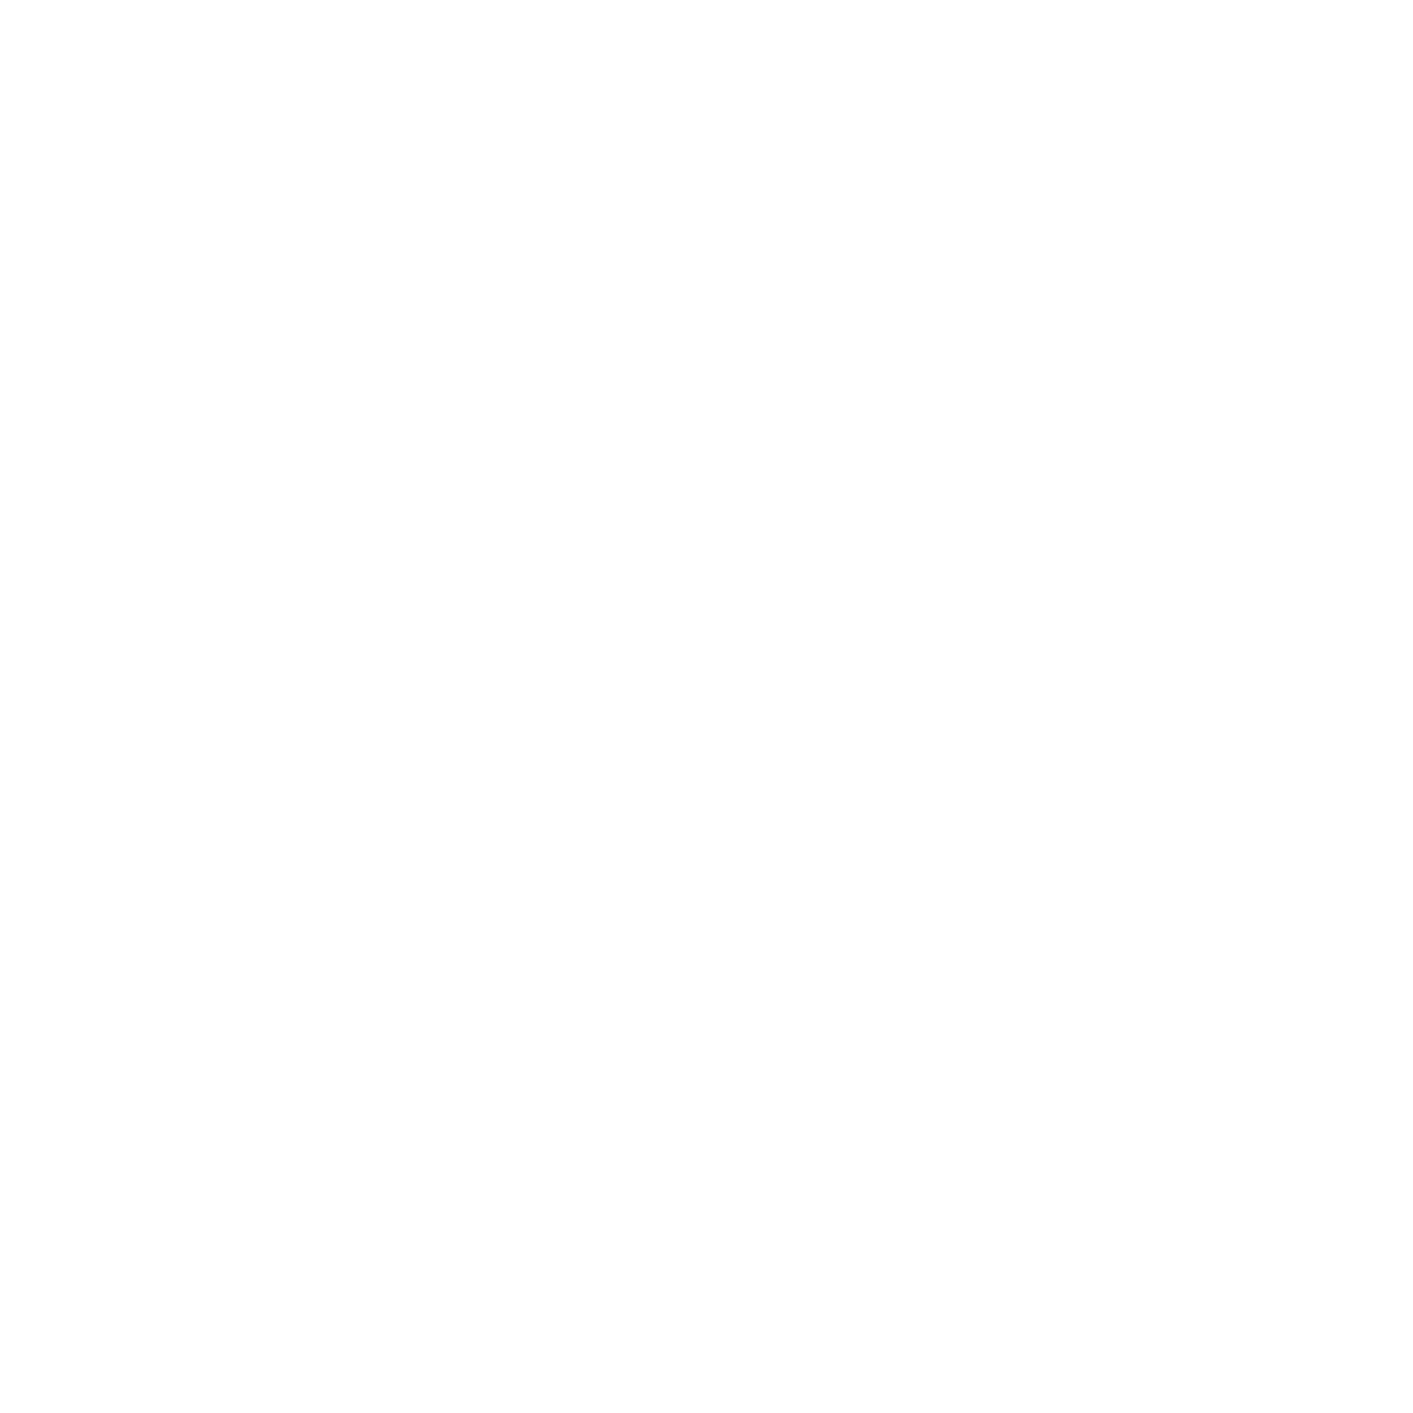

torch.Size([24, 19, 250])


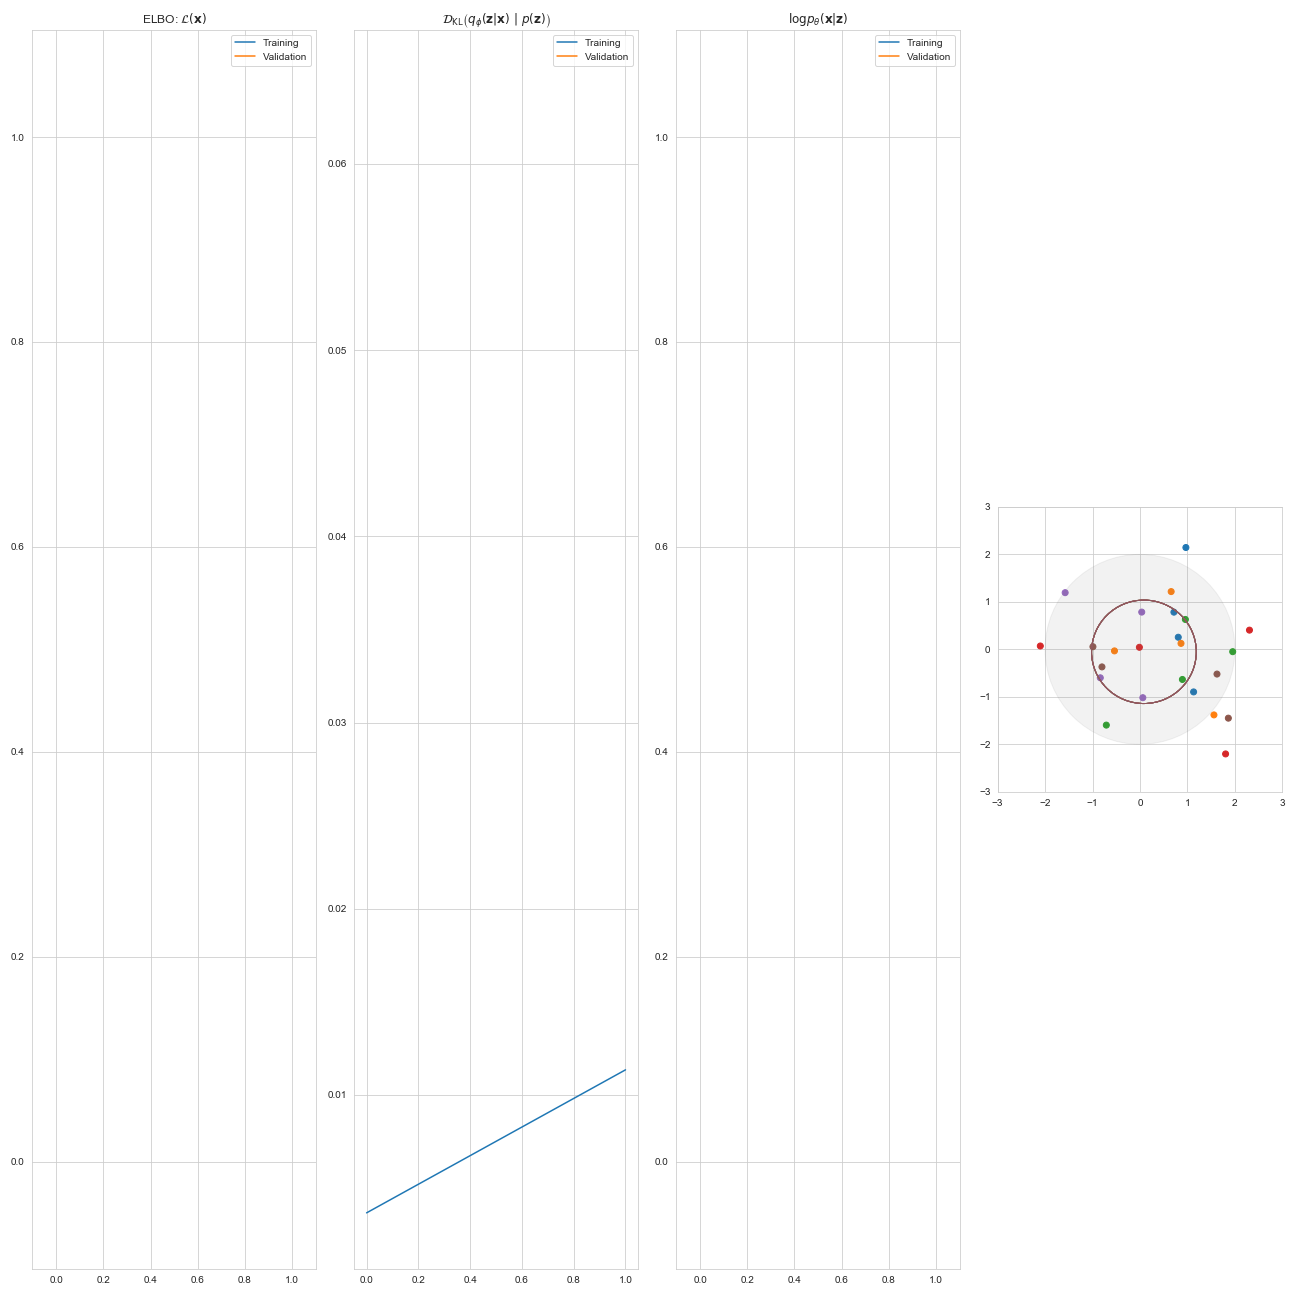

In [164]:
def make_vae_plots(vae, x, y, outputs, training_data, validation_data, tmp_img="tmp_vae_out.png", figsize=(18, 18)):
    fig, axes = plt.subplots(1, 4, figsize=figsize, squeeze=False)

    # plot the observation
   #axes[0, 0].set_title(r'Observation $\mathbf{x}$')
   #plot_samples(axes[0, 0], x)
    print(x.shape)
    # plot the latent samples
    try:
        z = outputs['z']
        if z.shape[1] == 2:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
            qz = outputs['qz']
            plot_2d_latents(axes[0, 3], qz, z, y)
        else:
            axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ (t-SNE)')
            plot_latents(axes[0, 3], z, y)
    except Exception as e:
        print(f"Could not generate the plot of the latent sanples because of exception")
        print(e)

    # plot posterior samples
    axes[0, 2].set_title(
        r'Reconstruction $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')
    px = outputs['px']
    x_sample = px.sample().to('cpu')
    #plot_samples(axes[0, 2], x_sample)

    # plot ELBO
    ax = axes[0, 0]
    ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    ax.plot(training_data['elbo'], label='Training')
    ax.plot(validation_data['elbo'], label='Validation')
    ax.legend()

    # plot KL
    ax = axes[0, 1]
    ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    ax.plot(training_data['kl'], label='Training')
    ax.plot(validation_data['kl'], label='Validation')
    ax.legend()

    # plot NLL
    ax = axes[0, 2]
    ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    ax.plot(training_data['log_px'], label='Training')
    ax.plot(validation_data['log_px'], label='Validation')
    ax.legend()

    # plot prior samples
    #axes[2, 0].set_title(r'Samples $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim p(\mathbf{z})$')
    #px = vae.sample_from_prior(batch_size=x.size(0))['px']
    #x_samples = px.sample()
    #plot_samples(axes[2, 0], x_samples)

    # plot interpolations samples
    #axes[2, 1].set_title(
        #'Latent Interpolations: $\mathbf{x} \sim p_\theta(\mathbf{x} | t \cdot \mathbf{z}_1 + (1-t) \cdot \mathbf{z}_2), \mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z}), t=0 \dots 1$')
    #plot_interpolations(axes[2, 1], vae)

    # plot samples (sampling from a grid instead of the prior)
    """
    if vae.latent_features == 2:
        axes[2, 2].set_title(
            r'Samples: $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim \operatorname{grid}(-3:3, -3:3)$')
        px = vae.sample_from_prior(batch_size=x.size(0))['px']
        x_samples = px.sample()
        plot_grid(axes[2, 2], vae)
    """
    # display
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)
    
make_vae_plots(vae, x, y, outputs, training_data, validation_data, tmp_img="tmp_vae_out.png", figsize=(18, 18))

<IPython.core.display.Javascript object>


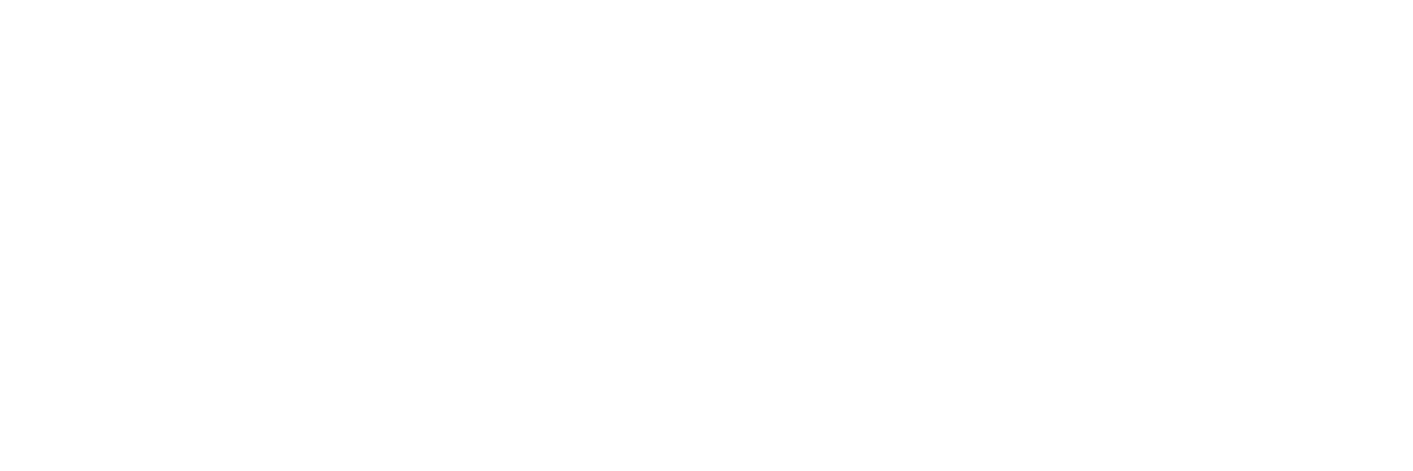

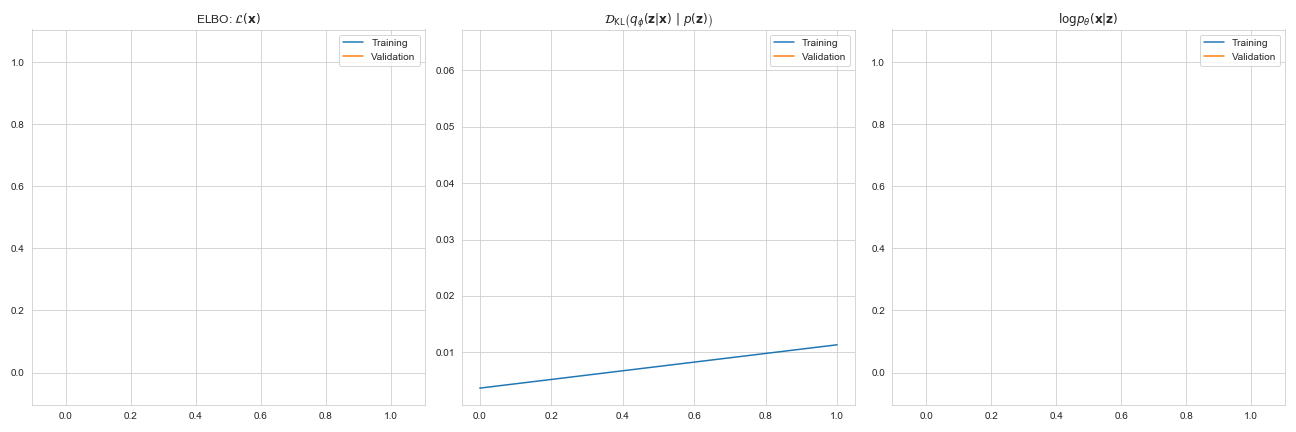

In [159]:
def plot_AC(training_data, validation_data,tmp_img="tmp_vae_ac.png",show=True ,figsize=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=figsize, squeeze=False)
    
    # plot ELBO
    ax = axes[0,0]
    ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    ax.plot(training_data['elbo'], label='Training')
    ax.plot(validation_data['elbo'], label='Validation')
    ax.legend()
    
    # plot KL
    ax = axes[0,1]
    ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    ax.plot(training_data['kl'], label='Training')
    ax.plot(validation_data['kl'], label='Validation')
    ax.legend()
    
    # plot NLL
    ax = axes[0,2]
    ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    ax.plot(training_data['log_px'], label='Training')
    ax.plot(validation_data['log_px'], label='Validation')
    ax.legend()
    
    # display
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    if show:
        display(Image(filename=tmp_img))
        clear_output(wait=True)


plot_AC(training_data, validation_data)


In [113]:
def plot_samples(ax, x):
    print("plotting sample")
    channels = 19
    fig, axs = plt.subplots(channels,figsize=(6,20))
    t = reshape(x)[0]

    for i in range(channels):
        axs[i].plot(t[i])
    ax=axs
    ax.axis('off')

In [62]:
def reshape(x):
    original_shape = (19, 250)
    if len(x.size())>1:
        return x.view(x.shape[0],*original_shape)
    return x.view(original_shape)

In [181]:

def plot_2d_latents(ax, outputs, y,tmp_img= "tmp_vae_latent_space.png",show=True):
    z = outputs['z']
    qz = outputs['qz']
    z = z.to('cpu')
    y = y.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    palette = sns.color_palette()
    colors = [palette[l] for l in y]

    # plot prior
    prior = plt.Circle((0, 0), scale_factor, color='gray', fill=True, alpha=0.1)
    ax.add_artist(prior)

    # plot data points
    mus, sigmas = qz.mu.to('cpu'), qz.sigma.to('cpu')
    mus = [mus[i].numpy().tolist() for i in range(batch_size)]
    sigmas = [sigmas[i].numpy().tolist() for i in range(batch_size)]

    posteriors = [
        plt.matplotlib.patches.Ellipse(mus[i], *(scale_factor * s for s in sigmas[i]), color=colors[i], fill=False,
                                       alpha=0.3) for i in range(batch_size)]
    for p in posteriors:
        ax.add_artist(p)

    ax.scatter(z[:, 0], z[:, 1], color=colors)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')
    
    # display
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    if show:
        display(Image(filename=tmp_img))
        clear_output(wait=True)

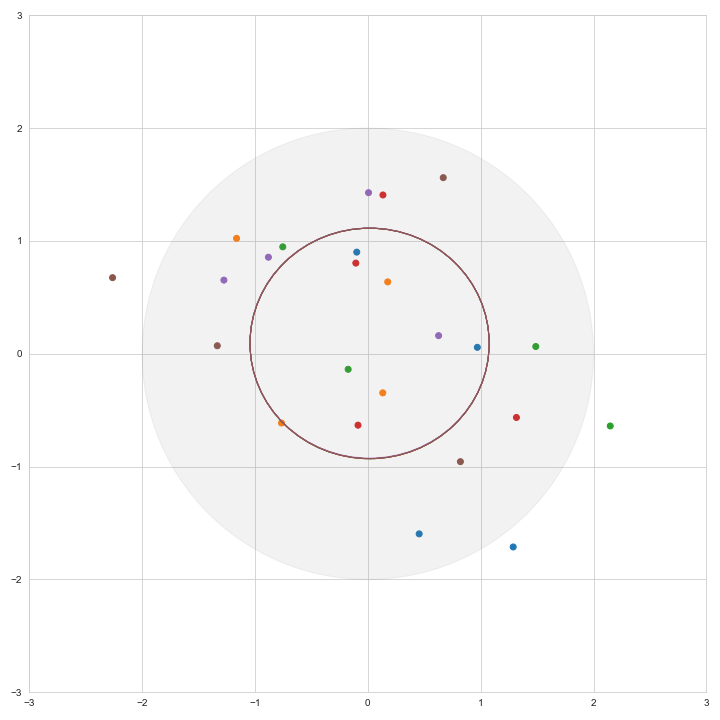

In [183]:

plot_AC(training_data, validation_data)
plot_2d_latents(axes[0,0], outputs, y)

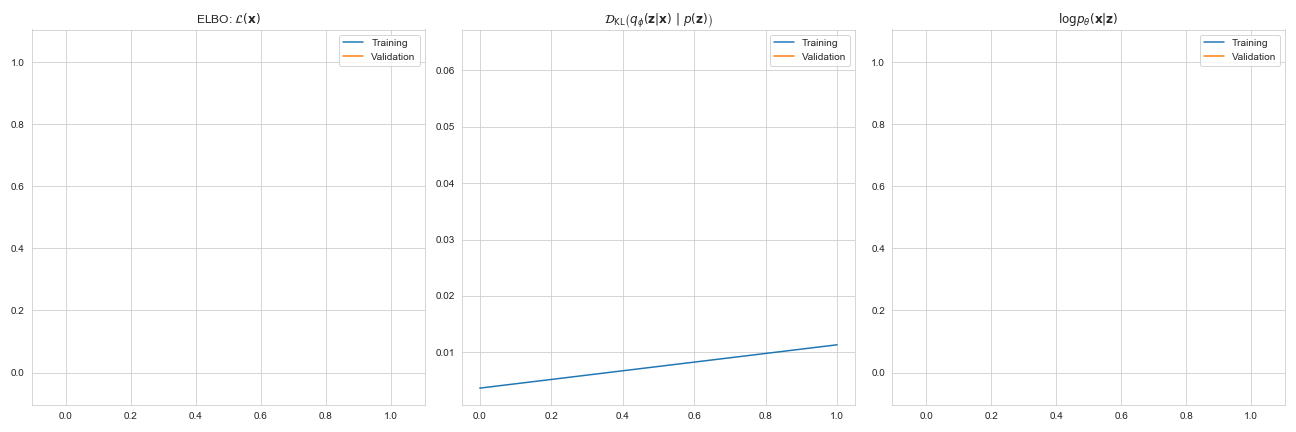

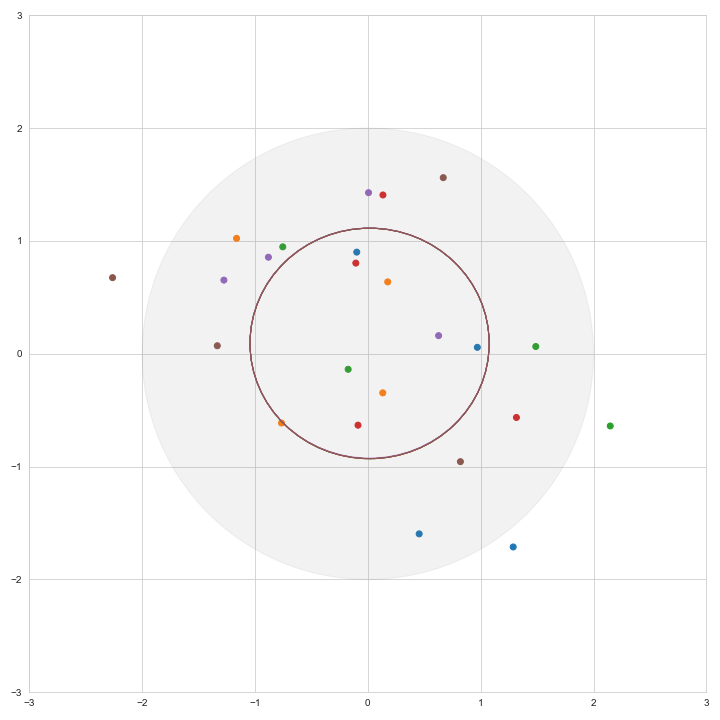

In [186]:
display(Image(filename="tmp_vae_ac.png"))
display(Image(filename="tmp_vae_latent_space.png"))

<IPython.core.display.Javascript object>


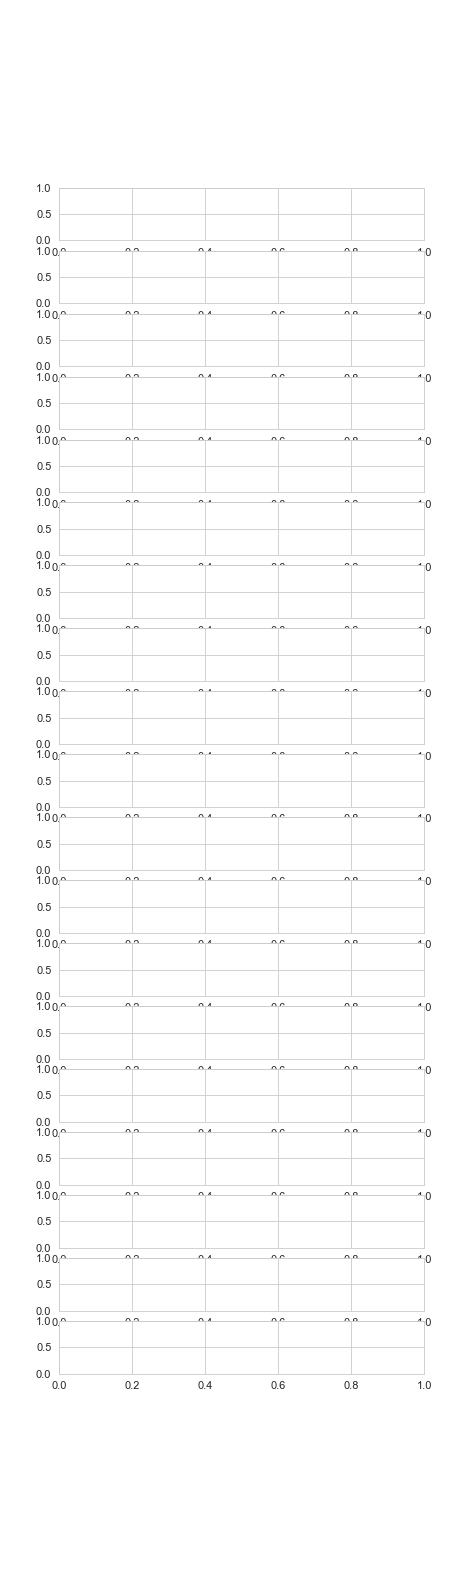

NameError: name 'x' is not defined

In [33]:
from torchvision.utils import make_grid

#x,y = load()
channels = 19
fig, axs = plt.subplots(channels,figsize=(6,20))
t = x[0]

for i in range(channels):
    axs[i].plot(t[i])

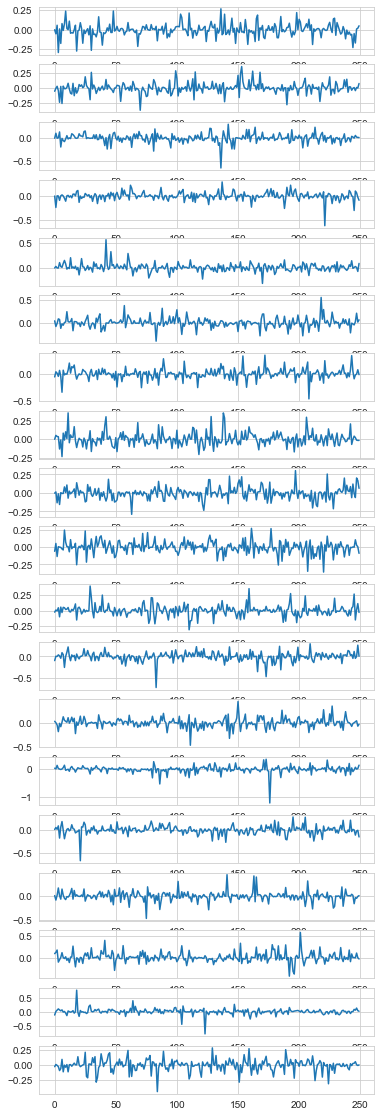

In [32]:
px = outputs['px']
x_sample = px.sample().to('cpu')

#x,y = load()
channels = 19
fig, axs = plt.subplots(channels,figsize=(6,20))
t = x_sample[0]

for i in range(channels):
    axs[i].plot(t[i])

In [ ]:
TRIGGER ERROR TO STOP RUNNING

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [ ]:
from sklearn import svm

def discriminativeTraining(vae,dataLoader,n_batches=10):
    
    x,y = load()        

    z = torch.empty(x.size()[0],2)

    for i in range(len(x)):
        z[i] = vae.posterior(x[i]).sample()
        
    for batch in range(n_batches):
        xi, yi = load()

        y = torch.cat((y,yi),0)     
        
        zi = torch.empty(x.size()[0],2)

        for i in range(len(x)):
            zi[i] = vae.posterior(x[i]).sample()
        z = torch.cat((z,zi))

    clf = svm.SVC()
    clf.fit(z, y) 
    return clf

**[SKIP]** Skip this section if training is not needed.

In [ ]:
SVC = discriminativeTraining(vae, DL)

In [ ]:
'''
filename = 'Saved_Models/svc.pkl'
pickle.dump(SVC, open(filename, 'wb'))
'''

**[END SKIP]**

In [35]:
filename = 'Saved_Models/svc.pkl'
SVC = pickle.load(open(filename, 'rb'))

In [ ]:
def get_z(vae,X):
    z = torch.empty(X.size()[0],2)
    for i in range(X.size()[0]):
        z[i] = vae.posterior(X[i]).sample()
    return z

In [ ]:
x_test, y_test = load()
z_test = get_z(vae,x_test)

y_pred = SVC.predict(z_test)

In [ ]:
SVC.score(z_test, y_test)

In [ ]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x